## TRAINING IMPLEMENTATION 

In this notebook: 
- training script to be run on GPU

## 1. Imports

In [1]:
import os
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
import scipy
from tqdm import tqdm
import seaborn as sns
import jax

from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
from functools import partial
import math
import csv
import time
from torch.utils.data import DataLoader
import numpy

from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))
from SSN_classes_jax_jit import SSN2DTopoV1_AMPAGABA_ONOFF
from SSN_classes_jax_on_only import SSN2DTopoV1_AMPAGABA
from util import GaborFilter, BW_Grating, find_A, create_gratings, create_data

from analysis import findRmax, plot_losses, plot_results, param_ratios

jax backend cpu


->Check GPU available

## 2. PARAMETERS TO DEFINE

### 2.1 Stimuli parameters

In [2]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 4

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 0, jitter_val = 5)
stimuli_pars.update(general_pars)

#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    A=None
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

class conn_pars():
    PERIODIC = False
    p_local = None
    J_2x2 = None
    s_2x2 = None
    sigma_oris = None
    w_sig = None
    b_sig = None
        
class filter_pars():
    sigma_g = numpy.array(0.5)
    conv_factor = numpy.array(2)
    k = numpy.array(1.0471975511965976)
    edge_deg = numpy.array( 3.2)
    degree_per_pixel = numpy.array(0.05)
    
class conv_pars:
    dt = 1
    xtol = 1e-05
    Tmax = 1000
    verbose = False
    silent = True
    Rmax_E = None
    Rmax_I= None

class loss_pars:
    lambda_1 = 1
    lambda_2 = 1
    lambda_w = 1.5
    lambda_b = 1

In [3]:
def init_set_func(init_set, middle = False):
    #ORIGINAL TRAINING!!
    if init_set ==4:
        Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
        gE, gI = 1,1
        sigEE, sigIE = 0.2, 0.40
        sigEI, sigII = .09, .09
        conn_pars.p_local = [0.4, 0.7]

    if init_set ==0:
        Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
        gE, gI = 0.57328625, 0.26144141
        sigEE, sigIE = 0.2, 0.40
        sigEI, sigII = .09, .09
        conn_pars.p_local = [0.4, 0.7]

    if init_set ==1:
        Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
        gE, gI = 0.37328625, 0.26144141
        sigEE, sigIE = 0.2, 0.40
        sigEI, sigII = .09, .09
        conn_pars.p_local = [0.4, 0.7]

    if init_set==2:
        Js0 = [1.72881688, 1.29887564, 1.48514091, 0.76417991]
        gE, gI = 0.5821754, 0.22660373
        sigEE, sigIE = 0.225, 0.242
        sigEI, sigII = .09, .09
        conn_pars.p_local = [0.0, 0.0]
    
    make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
    J_2x2 = make_J2x2(*Js0)
    s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

    
    #Middle layer only has J_2x2 parameters
    if middle:
        conn_pars.p_local = [1, 1]
    
    return J_2x2, s_2x2, gE, gI, conn_pars

In [4]:
init_set =4
J_2x2_sup, s_2x2_sup, gE, gI, conn_pars_sup  = init_set_func(init_set)
J_2x2_mid, s_2x2_mid, gE_mid, gI_mid, conn_pars_mid  = init_set_func(init_set, middle = True)

signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2_sup*signs)
logs_2x2 = np.log(s_2x2_sup)


#Excitatory and inhibitory constants for extra synaptic GABA
c_E = 5.0
c_I = 5.0

#Sigmoid parameters
N_neurons = 25


w_sig = np.asarray([ 0.29748327,  0.1410707 , -0.16734964,  0.09102286,
                0.32149637, -0.12738746,  0.23753586, -0.03877202,
                0.12324259,  0.10657982,  0.02443367,  0.05994884,
               -0.25580084,  0.01210546, -0.21458435,  0.08977108,
               -0.04690408, -0.05278951, -0.20510642,  0.00070886,
               -0.1308383 , -0.40605116, -0.16443379,  0.20746502,
                0.24199574])

b_sig = 0.0

sigma_oris = (np.asarray([1000.0, 1000.0])) #np.asarray([45.0, 45.0])
ssn_sup=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_sup, filter_pars=filter_pars, J_2x2=J_2x2_sup, s_2x2=s_2x2_sup, gE = gE, gI=gI, sigma_oris = sigma_oris)
ssn_pars.A=ssn_sup.A

ssn_middle=SSN2DTopoV1_AMPAGABA(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_sup, filter_pars=filter_pars, J_2x2=J_2x2_sup, s_2x2=s_2x2_sup, gE = gE, gI=gI, sigma_oris = sigma_oris)

### 2.3 Training params

In [5]:
#Number of epochs
epochs = 5
num_epochs_to_save =3
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)
epochs_to_save = np.insert(epochs_to_save, 0, 0)
noise_type = 'multiplicative'
model_type = 1

eta=10e-4
sig_noise = 2.5
batch_size = 50

In [6]:
#Name of results csv
home_dir = os.getcwd()

#Create directory for results
results_dir = os.path.join(home_dir, 'results', '13-03')
if os.path.exists(results_dir) == False:
        os.makedirs(results_dir)
        
    
results_name = 'set_'+str(init_set)+'_model_type_'+str(model_type)+'noise_2_mult_offset_'+str(offset)+'.csv' #SPECIFY NAME OF RESULTS FILE
if results_name == None:
    results_name = 'results.csv'

results_filename = os.path.join(results_dir, results_name)
print(results_filename)

/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/13-03/set_4_model_type_1noise_2_mult_offset_4.csv


## 3. TRAINING!

In [52]:
def save_params_dict(opt_pars, true_acc, ber_acc, epoch ):
    save_params = {}
    save_params= dict(epoch = epoch, val_accuracy= true_acc, 
                      ber_accuracy = ber_acc)
    
    for key in opt_pars.keys():
        
        if key =='logJ_2x2':
            J_2x2 = sep_exponentiate(opt_pars['logJ_2x2'])
            Js = dict(J_EE= J_2x2[0,0], J_EI = J_2x2[0,1], 
                              J_IE = J_2x2[1,0], J_II = J_2x2[1,1])
            save_params.update(Js)
        
        elif key =='logs_2x2':
            s_2x2 = np.exp(opt_pars['logs_2x2'])
            ss = dict(s_EE= s_2x2[0,0], s_EI = s_2x2[0,1], 
                              s_IE = s_2x2[1,0], s_II = s_2x2[1,1])
        
            save_params.update(ss)
        
        elif key=='sigma_oris':
            if len(opt_pars['sigma_oris']) ==1:
                save_params[key] = opt_pars[key]
            else:
                sigma_oris = dict(sigma_orisE = np.exp(opt_pars['sigma_oris'][0]), sigma_orisI = np.exp(opt_pars['sigma_oris'][1]))
                save_params.update(sigma_oris)
        
        elif key =='w_sig':
            save_params[key] = opt_pars[key]
            norm_w = np.linalg.norm(opt_pars[key])
            save_params['norm_w'] = norm_w
        
        else:
                save_params[key] = opt_pars[key]

    
    return save_params


def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])

    
    return J_2x2, s_2x2


def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data


def constant_to_vec(c_E, c_I, sup = False):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_I, vec_E, vec_I))
    
    if sup:
        constant_vec = np.hstack((vec_E, vec_I))
        
    return constant_vec

def our_max(x, beta=0.5):
    #nscipy function
    #max_val = scipy.special.logsumexp(x*beta)/beta
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val


def sigmoid(x, epsilon = 0.001):
    '''
    Introduction of epsilon stops asymptote from reaching 1 (avoids NaN)
    '''
    sig = 1/(1+np.exp(x))
    
    return (1 - 2*epsilon)*sig + epsilon


def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def obtain_fixed_point(ssn, ssn_input, conv_pars):
    
    r_init = np.zeros(ssn_input.shape[0])
    dt = conv_pars.dt
    xtol = conv_pars.xtol
    Tmax = conv_pars.Tmax
    verbose = conv_pars.verbose
    silent = conv_pars.silent
    
    #Find fixed point
    fp, _, avg_dx = ssn.fixed_point_r(ssn_input, r_init=r_init, dt=dt, xtol=xtol, Tmax=Tmax, verbose = verbose, silent=silent)

    avg_dx = np.maximum(0, (avg_dx -1))
    
    return fp, avg_dx


def middle_layer_fixed_point(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100, inhibition = False):
    
    fp, avg_dx = obtain_fixed_point(ssn, ssn_input, conv_pars)
    
    fp_E_on = ssn.select_type(fp, select='E_ON').ravel()
    fp_E_off = ssn.select_type(fp, select='E_OFF').ravel()
    
    layer_output = fp_E_on + fp_E_off
    
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))
    
    return layer_output, r_max, avg_dx
    

def obtain_fixed_point_centre_E(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100, inhibition = False):
    
    fp, avg_dx = obtain_fixed_point(ssn, ssn_input, conv_pars)
    #Apply bounding box to data
    r_box = (ssn.apply_bounding_box(fp, size=3.2)).ravel()
    
    #Obtain inhibitory response 
    if inhibition ==True:
        r_box_i = ssn.apply_bounding_box(fp, size=3.2, select='I_ON').ravel()
        r_box = [r_box, r_box_i]
        
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))
    return r_box, r_max, avg_dx


def take_log(J_2x2):
    
    signs=np.array([[1, -1], [1, -1]])
    logJ_2x2 =np.log(J_2x2*signs)
    
    return logJ_2x2


def sep_exponentiate(J_s):
    signs=np.array([[1, -1], [1, -1]]) 
    new_J =np.exp(J_s)*signs

    return new_J

def create_param_1(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    '''
    Training:logJ_2x2, log_s2x2, w_sig, b_sig, c_E, c_I
    '''
    
    opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
    conn_pars.sigma_oris = sigma_oris

    return opt_pars, conn_pars

def create_param_2(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    '''
    Training:logJ_2x2, sigma_oris, w_sig, b_sig, c_E, c_I
    '''
    
    opt_pars = dict(logJ_2x2 = logJ_2x2, sigma_oris = sigma_oris, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
    conn_pars.s_2x2 = logs_2x2

    return opt_pars, conn_pars

def create_param_3(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    '''
    Training:logJ_2x2, w_sig, b_sig, c_E, c_I
    '''
    
  
    opt_pars = dict(logJ_2x2 = logJ_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
    conn_pars.sigma_oris = sigma_oris
    conn_pars.s_2x2 = logs_2x2
    
    return opt_pars, conn_pars
    

def create_param_4(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    '''
    Training: w_sig, b_sig
    '''
    conn_pars.J_2x2 = logJ_2x2
    conn_pars.s_2x2 = logs_2x2
    conn_pars.sigma_oris = sigma_oris
    conn_pars.c_E = c_E
    conn_pars.c_I = c_I
    
    opt_pars = dict(w_sig = w_sig, b_sig = b_sig)

    return opt_pars, conn_pars


def create_param_5(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    '''
    Training: logJ_2x2, log_s2x2, c_E, c_I
    '''
    
    opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, c_E = c_E, c_I = c_I)
    conn_pars.sigma_oris = sigma_oris
    conn_pars.w_sig = w_sig
    conn_pars.b_sig = b_sig
    
    return opt_pars, conn_pars


    
def separate_param_1(opt_pars, conn_pars):
    logJ_2x2 = opt_pars['logJ_2x2']
    logs_2x2 = opt_pars['logs_2x2']
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']
    sigma_oris = conn_pars.sigma_oris
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris

def separate_param_2(opt_pars, conn_pars):
    
    logJ_2x2 = opt_pars['logJ_2x2']
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']
    sigma_oris=opt_pars['sigma_oris']
    log_s2x2 = conn_pars.s_2x2
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris


def separate_param_3(opt_pars, conn_pars):
    logJ_2x2 = opt_pars['logJ_2x2']
    logs_2x2 = conn_pars.s_2x2
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']
    sigma_oris = conn_pars.sigma_oris
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris


def separate_param_4(opt_pars, conn_pars):
    log_J_2x2 = conn_pars.J_2x2
    log_s_2x2 = conn_pars.s_2x2
    sigma_oris = conn_pars.sigma_oris
    c_E = conn_pars.c_E
    c_I = conn_pars.c_I
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris

def separate_param_5(opt_pars, conn_pars):
    logJ_2x2 = opt_pars['logJ_2x2']
    logs_2x2 = opt_pars['logs_2x2']
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    
    w_sig = conn_pars.w_sig
    b_sig = conn_pars.b_sig
    sigma_oris = conn_pars.sigma_oris
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris

@partial(jax.jit, static_argnums=( 7, 8, 9, 10, 11, 13, 14, 15, 17), device = jax.devices()[0])
def new_model(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars, gE, gI, train_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type='no_noise'):

    
    J_2x2 = sep_exponentiate(logJ_2x2)
    s_2x2 = np.exp(logs_2x2)
    sigma_oris = np.exp(sigma_oris)
    fE, fI = 1,1
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(c_E, c_I)
    
    #Initialise networks
    ssn_mid=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2, gE=gE, gI=gI, sigma_oris=sigma_oris)
    ssn_sup=SSN2DTopoV1_AMPAGABA(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2, gE=gE, gI=gI, sigma_oris=sigma_oris)
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn_mid.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn_mid.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Find fixed point for middle layer
    r_ref_mid, r_max_ref_mid, avg_dx_ref_mid = middle_layer_fixed_point(ssn_mid, SSN_input_ref, conv_pars)
    r_target_mid, r_max_target_mid, avg_dx_target_mid = middle_layer_fixed_point(ssn_mid, SSN_input_target, conv_pars)
    
    #Input to superficial layer
    sup_input_ref = np.hstack([r_ref_mid*fE, r_ref_mid*fI])
    sup_input_target = np.hstack([r_target_mid*fE, r_target_mid*fI])
    
    #Find fixed point for superficial layer
    r_ref, r_max_ref_sup, avg_dx_ref_sup= obtain_fixed_point_centre_E(ssn_sup, sup_input_ref, conv_pars)
    r_target, r_max_target_sup, avg_dx_target_sup= obtain_fixed_point_centre_E(ssn_sup, sup_input_target, conv_pars)

    #Add additional noise before sigmoid layer
    if noise_type =='additive':
        r_ref =r_ref + sig_noise*numpy.random.normal(size=(r_ref.shape))
        r_target = r_target + sig_noise*numpy.random.normal(size=(r_target.shape))
        
    elif noise_type == 'multiplicative':
        r_ref = r_ref*(1 + sig_noise*numpy.random.normal(size=(r_ref.shape)))
        r_target = r_target*(1 + sig_noise*numpy.random.normal(size=(r_target.shape)))
         
    elif noise_type =='poisson':
        r_ref = r_ref + sig_noise*np.sqrt(r_ref)*numpy.random.normal(size=(r_ref.shape))
        r_target = r_target + sig_noise*np.sqrt(r_target)*numpy.random.normal(size=(r_target.shape))

    elif noise_type =='no_noise':
        pass
    
    else:
        raise Exception('Noise type must be one of: additive, mulitiplicative, poisson')
    
    delta_x = r_ref - r_target
    
    #Apply sigmoid function - combine ref and target
    
    x = sigmoid( np.dot(w_sig, (delta_x)) + b_sig)
    
    #Calculate losses
    loss_binary=binary_loss(train_data['label'], x)
    loss_avg_dx = loss_pars.lambda_1*(avg_dx_ref_mid + avg_dx_target_mid)/2
    loss_r_max =  loss_pars.lambda_2*(r_max_ref_mid + r_max_target_mid)/2
    loss_w = loss_pars.lambda_w*(np.linalg.norm(w_sig)**2)
    loss_b = loss_pars.lambda_b*(b_sig**2)
    
    #Combine all losses
    loss = loss_binary + loss_w + loss_b # +  loss_avg_dx + loss_r_max
    all_losses = np.vstack((loss_binary, loss_avg_dx, loss_r_max, loss_w, loss_b, loss))
    
    pred_label = np.round(x) 
    
    #Calculate predicted label using Bernoulli distribution
    key_int = numpy.random.randint(low = 0, high =  10000)
    key = random.PRNGKey(key_int)
    pred_label_b = np.sum(jax.random.bernoulli(key, p=x, shape=None))

   
    return loss, all_losses, pred_label, pred_label_b



def loss(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type=1, evaluate=False):
    
    #Separate parameters
    if model_type==1:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_1(opt_pars, conn_pars)
        
    if model_type==2:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_2(opt_pars, conn_pars)
    
    if model_type==3:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_3(opt_pars, conn_pars)
    
    if model_type ==4:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_4(opt_pars, conn_pars)
        
    if model_type ==5:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_5(opt_pars, conn_pars)
    
    total_loss, all_losses, pred_label, pred_label_b= vmap_model(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type)
    
    loss= np.mean(total_loss)
    all_losses = np.mean(all_losses, axis = 0)

    
    #if evaluate ==True:
        #Find accuracy based on predicted labels
        
    true_accuracy = np.sum(test_data['label'] == pred_label)/len(test_data['label']) 
    ber_accuracy = np.sum(test_data['label'] == pred_label_b)/len(test_data['label']) 
       
        
    return loss, [all_losses, true_accuracy, ber_accuracy]
    

    
    
def train_SSN_vmap(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, ssn_pars, grid_pars, conn_pars, gE, gI, stimuli_pars, filter_pars, conv_pars, loss_pars, epochs_to_save, results_filename = None, batch_size=20, ref_ori = 55, offset = 5, epochs=1, eta=10e-4, sig_noise = None, test_size = None, noise_type='additive', model_type=1, readout_pars=None, early_stop = 0.6):
          
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
    train_accs = []
    
    test_size = batch_size if test_size is None else test_size
    
    #Initialise vmap version of model
    vmap_model = vmap(new_model, in_axes = (None, None, None, None, None, None, None, None, None, None, None, None, {'ref':0, 'target':0, 'label':0}, None, None, None, None, None) )
    
    #Separate parameters used in optimisation
    if model_type ==1:
        opt_pars, conn_pars = create_param_1(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars)
    
    if model_type==2:
        opt_pars, conn_pars = create_param_2(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars)
    
    if model_type==3:
        opt_pars, conn_pars = create_param_3(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars)
    
    if model_type ==4:
        opt_pars, conn_pars= create_param_4(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars)
        
    if model_type ==5:
        opt_pars, conn_pars = create_param_5(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars)
    
    #Initialise optimizer
    optimizer = optax.adam(eta)
    opt_state = optimizer.init(opt_pars)
    
    print(opt_pars)
    
    print('Training model with learning rate {}, sig_noise {} at offset {}, lam_w {}, batch size {}, noise_type {}'.format(eta, sig_noise, offset, loss_pars.lambda_w, batch_size, noise_type))
    
    #Define test data - no need to iterate
    test_data = create_data(stimuli_pars, number = test_size, offset = offset, ref_ori = ref_ori)
    val_loss, [all_losses, true_acc, ber_acc]= loss(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type, evaluate = True)
    print('Before training  -- loss: {}, true accuracy: {} , Bernoulli accuracy: {}'.format(np.round(float(val_loss), 3), np.round(true_acc, 3), np.round(ber_acc, 3)))
    val_loss_per_epoch.append(val_loss)
    
    #Save initial parameters
    initial_save_params = save_params_dict(opt_pars=opt_pars, true_acc=true_acc, ber_acc = ber_acc, epoch=0)
    
    #Initialise csv file
    if results_filename:
        results_handle = open(results_filename, 'w')
        results_writer = csv.DictWriter(results_handle, fieldnames=initial_save_params.keys(), delimiter=',')
        results_writer.writeheader()
        results_writer.writerow(initial_save_params)
        print('Saving results to csv ', results_filename)
    else:
        print('#### NOT SAVING! ####')
    
    loss_and_grad = jax.value_and_grad(loss, has_aux = True)
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0 
           
        #Load next batch of data and convert
        train_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

        #Compute loss and gradient
        [epoch_loss, [epoch_all_losses, train_true_acc, train_ber_acc]], grad =loss_and_grad(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, train_data, filter_pars, conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type)
        training_losses.append(epoch_loss)
        all_losses = np.hstack((all_losses, epoch_all_losses))
        train_accs.append(train_true_acc)
        
        epoch_time = time.time() - start_time
        
        if model_type ==4 and epoch>5 and np.mean(np.asarray(train_accs[-5:]))>early_stop:
                print('Early stop: {} accuracy achieved at epoch {}'.format(early_stop, epoch))
                break

        #Save the parameters given a number of epochs
        if epoch in epochs_to_save:
            
            #Evaluate model 
            test_data = create_data(stimuli_pars, number = test_size, offset = offset, ref_ori = ref_ori)
            start_time = time.time()
            val_loss, [val_all_losses, true_acc, ber_acc]= loss(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type, evaluate = True)
            val_time = time.time() - start_time
            print('Training loss: {} ¦ Validation -- loss: {}, true accuracy: {}, Bernoulli accuracy: {} at epoch {}, (time {}, {})'.format(epoch_loss, val_loss, true_acc, ber_acc, epoch, epoch_time, val_time))
            val_loss_per_epoch.append(val_loss)
            #Create dictionary of parameters to save
            
                
        updates, opt_state = optimizer.update(grad, opt_state)
        opt_pars = optax.apply_updates(opt_pars, updates)
    
        #Save new optimized parameters
        if epoch in epochs_to_save:
            if results_filename:
                save_params = save_params_dict(opt_pars=opt_pars, true_acc=true_acc, ber_acc=ber_acc, epoch=epoch)
                results_writer.writerow(save_params)
    
    #Reparametize parameters
    signs=np.array([[1, -1], [1, -1]])
    if 'logJ_2x2' in opt_pars.keys():
        opt_pars['logJ_2x2'] = np.exp(opt_pars['logJ_2x2'])*signs
    if 'logs_2x2' in opt_pars.keys():
        opt_pars['logs_2x2'] = np.exp(opt_pars['logs_2x2'])
    if 'sigma_oris' in opt_pars.keys():
        opt_pars['sigma_oris'] = np.exp(opt_pars['sigma_oris'])
   
    return opt_pars, val_loss_per_epoch, all_losses, train_accs



In [53]:
new_opt_pars, val_loss_per_epoch, training_losses, training_accs = train_SSN_vmap(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, ssn_pars, grid_pars, conn_pars, gE, gI, stimuli_pars, filter_pars, conv_pars, loss_pars, epochs_to_save, results_filename = None, batch_size=batch_size, ref_ori = ref_ori, offset = offset, epochs=epochs, eta=eta, sig_noise = sig_noise, noise_type=noise_type, model_type=model_type)

{'logJ_2x2': DeviceArray([[1.4909518 , 0.5057398 ],
             [1.6152025 , 0.21644054]], dtype=float32), 'logs_2x2': DeviceArray([[-1.609438 , -2.4079456],
             [-0.9162907, -2.4079456]], dtype=float32), 'w_sig': DeviceArray([ 0.29748327,  0.1410707 , -0.16734964,  0.09102286,
              0.32149637, -0.12738746,  0.23753586, -0.03877202,
              0.12324259,  0.10657982,  0.02443367,  0.05994884,
             -0.25580084,  0.01210546, -0.21458435,  0.08977108,
             -0.04690408, -0.05278951, -0.20510642,  0.00070886,
             -0.1308383 , -0.40605116, -0.16443379,  0.20746502,
              0.24199574], dtype=float32), 'b_sig': 0.0, 'c_E': 5.0, 'c_I': 5.0}
Training model with learning rate 0.001, sig_noise 2.5 at offset 4, lam_w 1.5, batch size 50, noise_type multiplicative
Before training  -- loss: 3.750000238418579, true accuracy: 0.5400000214576721 , Bernoulli accuracy: 0.5400000214576721
#### NOT SAVING! ####


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fe5cd0694c0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt



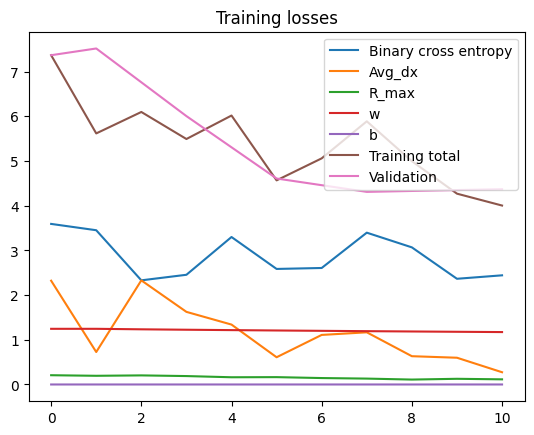

In [35]:
np.save(os.path.join(results_dir, 'training_losses.npy'), training_losses)
np.save(os.path.join(results_dir, 'validation_losses.npy'), val_loss_per_epoch)

losses_dir = os.path.join(results_dir, 'mult_losses_set_'+str(init_set)+'_model_type_'+str(model_type)+'offset_'+str(offset))
plot_losses(training_losses, val_loss_per_epoch, epochs_to_save, save = losses_dir)

In [39]:
results_plot_dir = os.path.join(results_dir, 'mult_results_set_'+str(init_set)+'_model_type_'+str(model_type)+'offset_'+str(offset) )
plot_results(results_filename, save=results_plot_dir)

NameError: name 'results_filename' is not defined

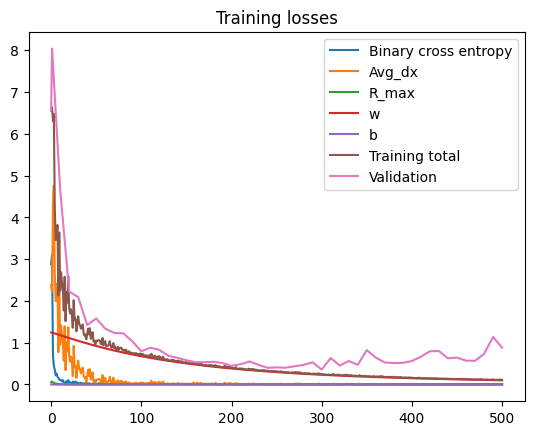

In [16]:
#plot_losses(load_losses, load_val_losses, epochs_to_save, save = saving_dit)